there are 2 patents
Closest patent assignee is:  INDUSTRIAL TECHNOLOGY RESEARCH INSTITUTE
Closest patent assignee is:  Aquidneck Systems International, Inc.
There are 0 patents with no closest patent
patents with no citation: 0
paetnts with citation : 2
{-4: 26, -3: 31, -2: 22, -1: 8, 0: 17, 1: 13, 2: 8, 3: 4, 4: 2}
{-4: 4, -3: 12, -2: 7, -1: 1, 0: 6, 1: 6, 2: 4, 3: 0, 4: 0}
{-4: 2, -3: 2, -2: 2, -1: 2, 0: 2, 1: 2, 2: 2, 3: 2, 4: 2}
{-4: 2, -3: 2, -2: 2, -1: 2, 0: 2, 1: 2, 2: 2, 3: 2, 4: 2}


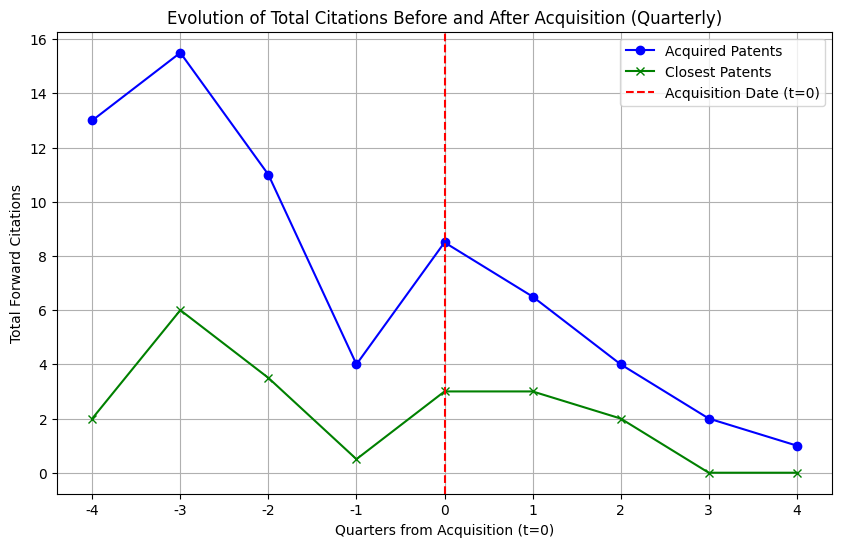

In [5]:
## Inputs
import dill as pickle
from datetime import datetime
from collections import OrderedDict
import time
with open(r"C:\Users\amusali\Desktop\uc3m PhD\05 Analysis\01 Main\00 Python data\04 Patents with pairs (group checked, regularized, only before)\Stac Electronics, Inc._1994-06-20_before.pkl", 'rb') as f:
    t = pickle.load(f)
import matplotlib.pyplot as plt
import numpy as np

patents = t
center_date=datetime(2016, 12, 7)
no_closest_patent_counter = 0
no_cited_patent_counter = 0
patents_with_citation = 0

upper_lower_bound = 4
implied_days = 365
threshold = 365
# Initialize dictionaries to hold citation counts for each time point (quarters)

time_range=(-upper_lower_bound, upper_lower_bound)
patent_citations_by_time = {t: 0 for t in range(time_range[0], time_range[1] + 1)}
patent_count_by_time = {t: 0 for t in range(time_range[0], time_range[1] + 1)}
closest_citations_by_time = {t: 0 for t in range(time_range[0], time_range[1] + 1)}
closest_count_by_time =  {t: 0 for t in range(time_range[0], time_range[1] + 1)}

print("there are", len(patents), "patents")
for patent in patents:
    if patent.cosine_similarity_with_closest_patent is not None:
        if patent.cosine_similarity_with_closest_patent < 0.7:
            continue
    if patent.forward_citations  == 0 or not patent.forward_citations or patent.closest_patent.forward_citations == 0 or not patent.closest_patent.forward_citations :
        no_cited_patent_counter += 1
        continue
    if (patent.date_granted - center_date).days > -threshold or (patent.closest_patent.date_granted - center_date).days > -threshold:
        #print("BEFORE THE ANALYSIS Period")
        continue
    #if -(patent.date_granted - center_date).days < upper_lower_bound * implied_days:
      # print("Too close to the acquistion")
        #continue
    if patent.closest_patent is None:
        print('None closes patent')
        no_closest_patent_counter +=1
        continue

    print("Closest patent assignee is: ", patent.closest_patent.assignee_organization)
    # Check if the patent has any citedby_patents
    if patent.citedby_patents:
        for cited_patent in patent.citedby_patents:
            #print(cited_patent.date_granted)
            # Calculate time difference (in quarters) from the center date
            t_patent = (cited_patent.date_granted - center_date).days // implied_days  # Approx. 91 days in a quarter
            #print(t_patent)
            if time_range[0] <= t_patent <= time_range[1]:
                patent_citations_by_time[t_patent] += 1  # Add 1 citation for this quarter
    time_to_acquisition = (patent.date_granted - center_date).days // implied_days
    
    for key, value in patent_count_by_time.items():
        if key >= time_to_acquisition:
            patent_count_by_time[key] += 1
    # Check if the closest patent exists and has any citedby_patents
    if patent.closest_patent and patent.closest_patent.citedby_patents:
        for cited_patent in patent.closest_patent.citedby_patents:
            t_closest = (cited_patent.date_granted - center_date).days // implied_days  # Time difference in quarters
            if time_range[0] <= t_closest <= time_range[1]:
                closest_citations_by_time[t_closest] += 1 # Add 1 citation for this quarter

    time_to_acquisition = (patent.closest_patent.date_granted - center_date).days // implied_days
    
    for key, value in closest_count_by_time.items():
        if key >= time_to_acquisition:
            closest_count_by_time[key] += 1

    patents_with_citation += 1

print(f"There are {no_closest_patent_counter} patents with no closest patent")
print(f"patents with no citation: {no_cited_patent_counter}")   
print(f"paetnts with citation : {patents_with_citation}")

print(patent_citations_by_time)
print(closest_citations_by_time)
print(patent_count_by_time)
print(closest_count_by_time)

# Calculate average citations for each time point (quarter)
avg_patent_citations = [patent_citations_by_time[t]/patent_count_by_time[t] for t in range(time_range[0], time_range[1] + 1)]
avg_closest_citations = [closest_citations_by_time[t]/closest_count_by_time[t] for t in range(time_range[0], time_range[1] + 1)]




# Create the x-axis (time points in quarters)
time_points = list(range(time_range[0], time_range[1] + 1))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(time_points, avg_patent_citations, label='Acquired Patents', marker='o', color='blue')
plt.plot(time_points, avg_closest_citations, label='Closest Patents', marker='x', color='green')

# Highlight t=0 (acquisition date)
plt.axvline(x=0, color='red', linestyle='--', label='Acquisition Date (t=0)')

plt.title("Evolution of Total Citations Before and After Acquisition (Quarterly)")
plt.xlabel("Quarters from Acquisition (t=0)")
plt.ylabel("Total Forward Citations")
plt.xticks(np.arange(time_range[0], time_range[1] + 1), labels=[f"{i}" for i in range(time_range[0], time_range[1] + 1)])
plt.legend()
plt.grid(True)
plt.show()





In [8]:
import api.citations as cit
import importlib
importlib.reload(cit)

cit.regularize_patents(patents)

0.8944083300348538
Processed patent 0/2
0.844448311113904
Processed patent 1/2
Skipped patents (no closest_patent): []


([Patent(patent_id='5126739', abstract='An apparatus and method as disclosed for converting an input data character stream into a variable length encoded data stream in a data compression system. The data compression system includes a history array means. The history array means has a plurality of entries and each entry of the history array means is for storing a portion of the input data stream. The method for converting the input data character stream includes the following steps. Performing a search in a history array means for the longest data string which matches the input data string. If the matching data string is found within the history buffer means, the next step includes encoding the longest matching data string found by appending to the encoded data stream a tag indicating the longest matching data string was found and a string substitution code. If the matching data string is not found within the history array means, the next step includes encoding the first character of t

In [7]:
for pat in patents:
    print(pat.cosine_similarity_with_closest_patent)

0.8944083300348538
0.8444734


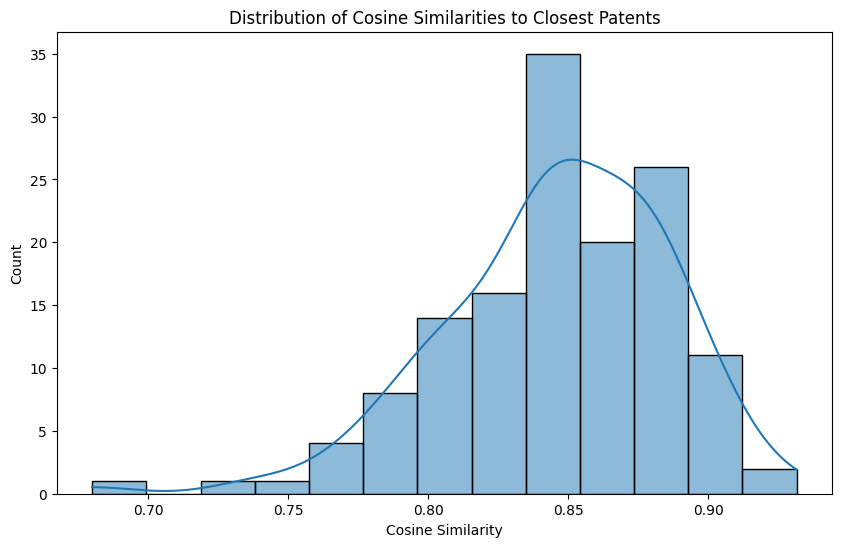

Number of patents with similarities calculated: 1135


TypeError: unsupported operand type(s) for +: 'NoneType' and 'NoneType'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cosine
import seaborn as sns

# Calculate cosine similarities
cosine_similarities = []

for patent in patents:

    cosine_similarities.append(patent.cosine_similarity_with_closest_patent)

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(cosine_similarities, kde=True)
plt.title("Distribution of Cosine Similarities to Closest Patents")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.show()

# Print some statistics
print(f"Number of patents with similarities calculated: {len(cosine_similarities)}")
print(f"Mean similarity: {np.mean(cosine_similarities):.4f}")
print(f"Median similarity: {np.median(cosine_similarities):.4f}")
print(f"Min similarity: {np.min(cosine_similarities):.4f}")
print(f"Max similarity: {np.max(cosine_similarities):.4f}")

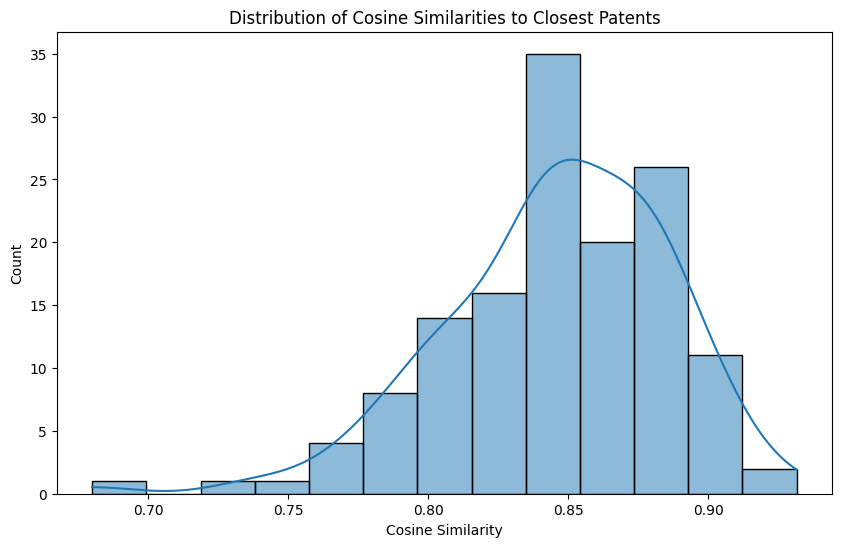

Number of patents with similarities calculated: 1135


TypeError: unsupported operand type(s) for +: 'NoneType' and 'NoneType'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cosine
import seaborn as sns

# Calculate cosine similarities
cosine_similarities = []

for patent in patents:

    cosine_similarities.append(patent.cosine_similarity_with_closest_patent)

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(cosine_similarities, kde=True)
plt.title("Distribution of Cosine Similarities to Closest Patents")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.show()

# Print some statistics
print(f"Number of patents with similarities calculated: {len(cosine_similarities)}")
print(f"Mean similarity: {np.mean(cosine_similarities):.4f}")
print(f"Median similarity: {np.median(cosine_similarities):.4f}")
print(f"Min similarity: {np.min(cosine_similarities):.4f}")
print(f"Max similarity: {np.max(cosine_similarities):.4f}")

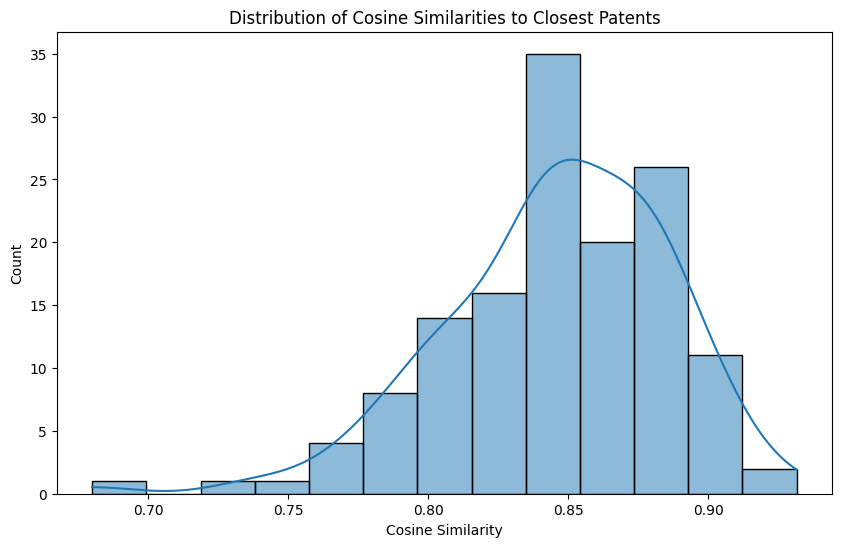

Number of patents with similarities calculated: 1135


TypeError: unsupported operand type(s) for +: 'NoneType' and 'NoneType'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cosine
import seaborn as sns

# Calculate cosine similarities
cosine_similarities = []

for patent in patents:

    cosine_similarities.append(patent.cosine_similarity_with_closest_patent)

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(cosine_similarities, kde=True)
plt.title("Distribution of Cosine Similarities to Closest Patents")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.show()

# Print some statistics
print(f"Number of patents with similarities calculated: {len(cosine_similarities)}")
print(f"Mean similarity: {np.mean(cosine_similarities):.4f}")
print(f"Median similarity: {np.median(cosine_similarities):.4f}")
print(f"Min similarity: {np.min(cosine_similarities):.4f}")
print(f"Max similarity: {np.max(cosine_similarities):.4f}")

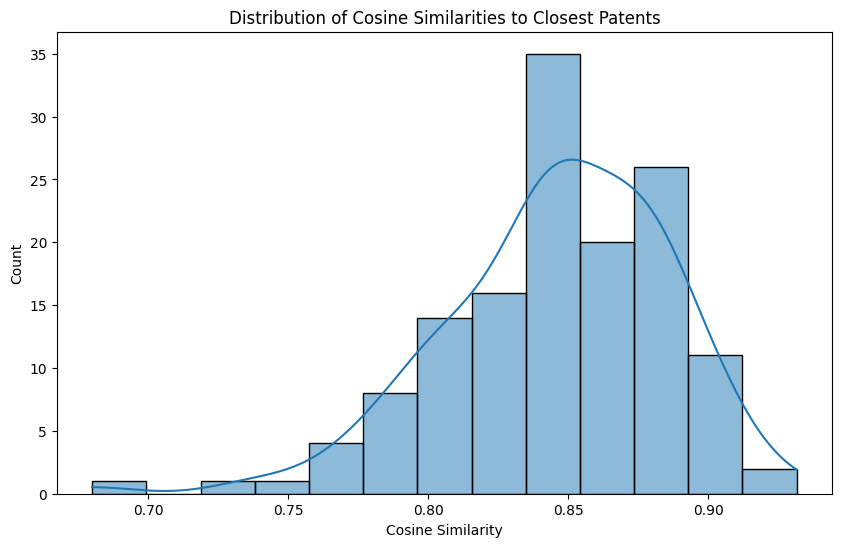

Number of patents with similarities calculated: 1135


TypeError: unsupported operand type(s) for +: 'NoneType' and 'NoneType'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cosine
import seaborn as sns

# Calculate cosine similarities
cosine_similarities = []

for patent in patents:

    cosine_similarities.append(patent.cosine_similarity_with_closest_patent)

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(cosine_similarities, kde=True)
plt.title("Distribution of Cosine Similarities to Closest Patents")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.show()

# Print some statistics
print(f"Number of patents with similarities calculated: {len(cosine_similarities)}")
print(f"Mean similarity: {np.mean(cosine_similarities):.4f}")
print(f"Median similarity: {np.median(cosine_similarities):.4f}")
print(f"Min similarity: {np.min(cosine_similarities):.4f}")
print(f"Max similarity: {np.max(cosine_similarities):.4f}")

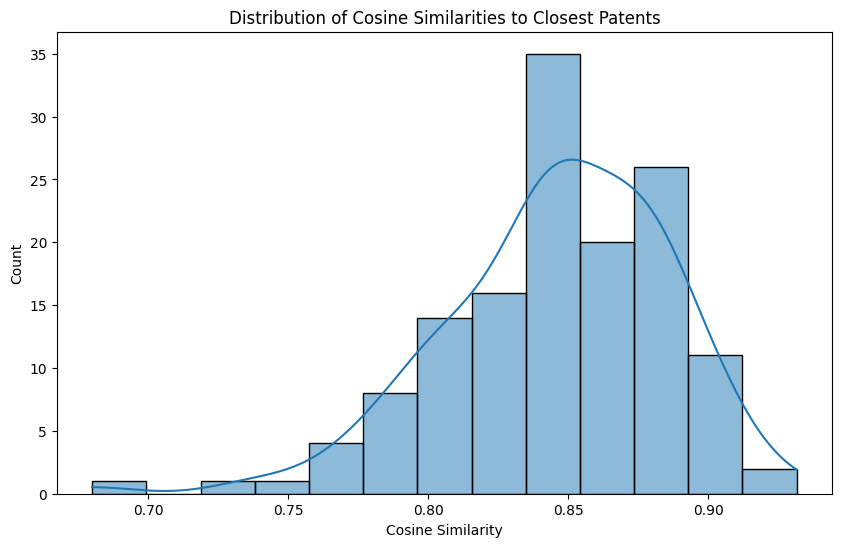

Number of patents with similarities calculated: 1135


TypeError: unsupported operand type(s) for +: 'NoneType' and 'NoneType'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cosine
import seaborn as sns

# Calculate cosine similarities
cosine_similarities = []

for patent in patents:

    cosine_similarities.append(patent.cosine_similarity_with_closest_patent)

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(cosine_similarities, kde=True)
plt.title("Distribution of Cosine Similarities to Closest Patents")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.show()

# Print some statistics
print(f"Number of patents with similarities calculated: {len(cosine_similarities)}")
print(f"Mean similarity: {np.mean(cosine_similarities):.4f}")
print(f"Median similarity: {np.median(cosine_similarities):.4f}")
print(f"Min similarity: {np.min(cosine_similarities):.4f}")
print(f"Max similarity: {np.max(cosine_similarities):.4f}")

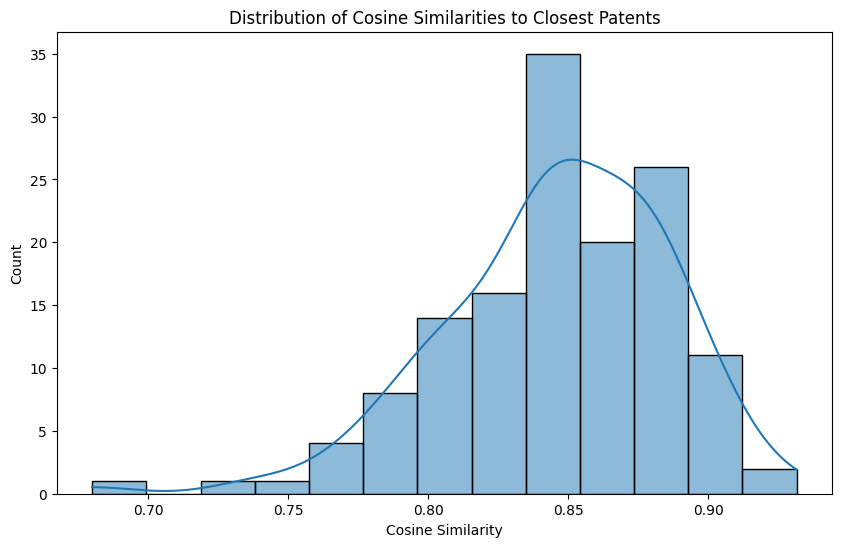

Number of patents with similarities calculated: 1135


TypeError: unsupported operand type(s) for +: 'NoneType' and 'NoneType'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cosine
import seaborn as sns

# Calculate cosine similarities
cosine_similarities = []

for patent in patents:

    cosine_similarities.append(patent.cosine_similarity_with_closest_patent)

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(cosine_similarities, kde=True)
plt.title("Distribution of Cosine Similarities to Closest Patents")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.show()

# Print some statistics
print(f"Number of patents with similarities calculated: {len(cosine_similarities)}")
print(f"Mean similarity: {np.mean(cosine_similarities):.4f}")
print(f"Median similarity: {np.median(cosine_similarities):.4f}")
print(f"Min similarity: {np.min(cosine_similarities):.4f}")
print(f"Max similarity: {np.max(cosine_similarities):.4f}")

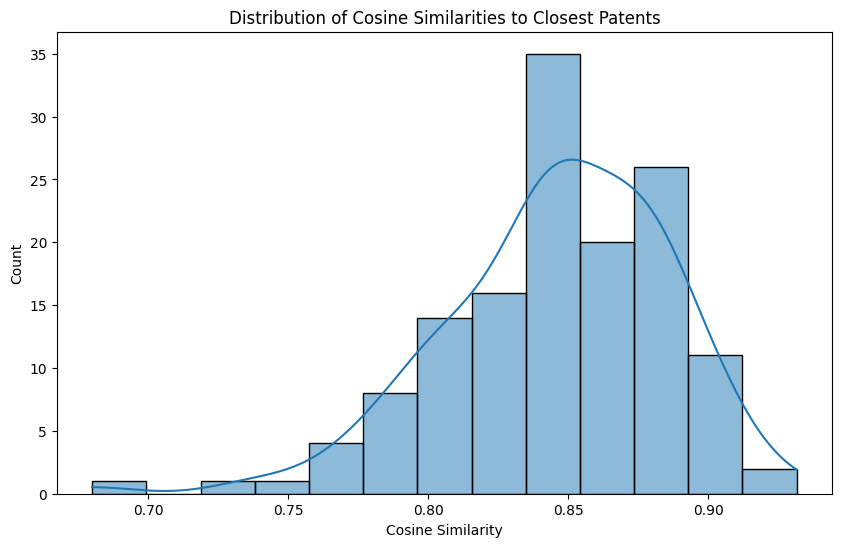

Number of patents with similarities calculated: 1135


TypeError: unsupported operand type(s) for +: 'NoneType' and 'NoneType'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cosine
import seaborn as sns

# Calculate cosine similarities
cosine_similarities = []

for patent in patents:

    cosine_similarities.append(patent.cosine_similarity_with_closest_patent)

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(cosine_similarities, kde=True)
plt.title("Distribution of Cosine Similarities to Closest Patents")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.show()

# Print some statistics
print(f"Number of patents with similarities calculated: {len(cosine_similarities)}")
print(f"Mean similarity: {np.mean(cosine_similarities):.4f}")
print(f"Median similarity: {np.median(cosine_similarities):.4f}")
print(f"Min similarity: {np.min(cosine_similarities):.4f}")
print(f"Max similarity: {np.max(cosine_similarities):.4f}")

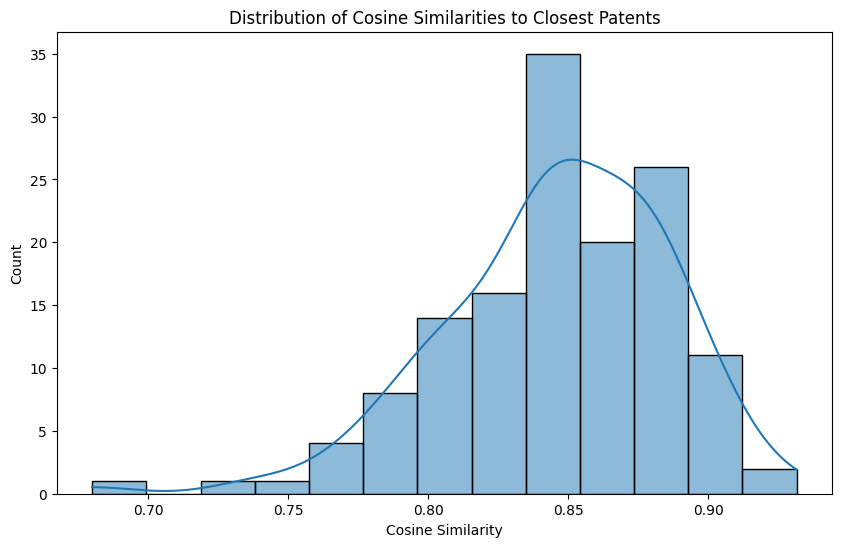

Number of patents with similarities calculated: 1135


TypeError: unsupported operand type(s) for +: 'NoneType' and 'NoneType'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cosine
import seaborn as sns

# Calculate cosine similarities
cosine_similarities = []

for patent in patents:

    cosine_similarities.append(patent.cosine_similarity_with_closest_patent)

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(cosine_similarities, kde=True)
plt.title("Distribution of Cosine Similarities to Closest Patents")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.show()

# Print some statistics
print(f"Number of patents with similarities calculated: {len(cosine_similarities)}")
print(f"Mean similarity: {np.mean(cosine_similarities):.4f}")
print(f"Median similarity: {np.median(cosine_similarities):.4f}")
print(f"Min similarity: {np.min(cosine_similarities):.4f}")
print(f"Max similarity: {np.max(cosine_similarities):.4f}")

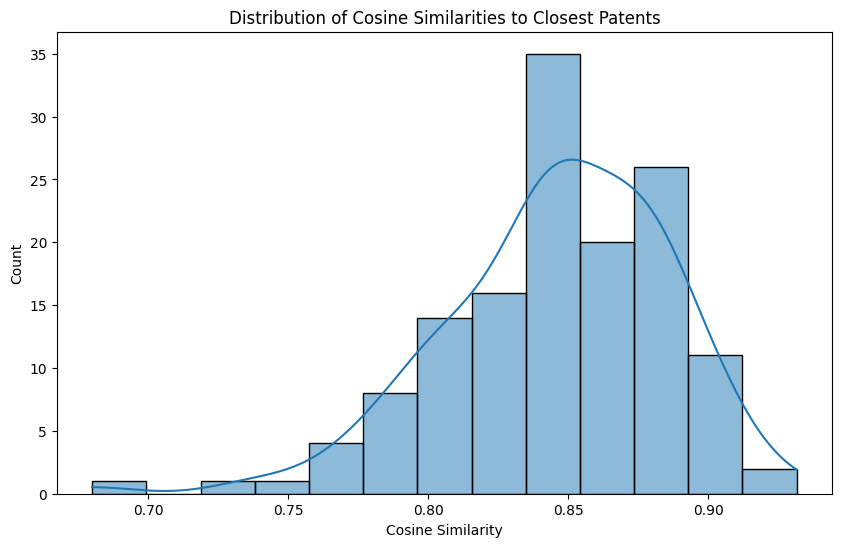

Number of patents with similarities calculated: 1135


TypeError: unsupported operand type(s) for +: 'NoneType' and 'NoneType'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cosine
import seaborn as sns

# Calculate cosine similarities
cosine_similarities = []

for patent in patents:

    cosine_similarities.append(patent.cosine_similarity_with_closest_patent)

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(cosine_similarities, kde=True)
plt.title("Distribution of Cosine Similarities to Closest Patents")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.show()

# Print some statistics
print(f"Number of patents with similarities calculated: {len(cosine_similarities)}")
print(f"Mean similarity: {np.mean(cosine_similarities):.4f}")
print(f"Median similarity: {np.median(cosine_similarities):.4f}")
print(f"Min similarity: {np.min(cosine_similarities):.4f}")
print(f"Max similarity: {np.max(cosine_similarities):.4f}")

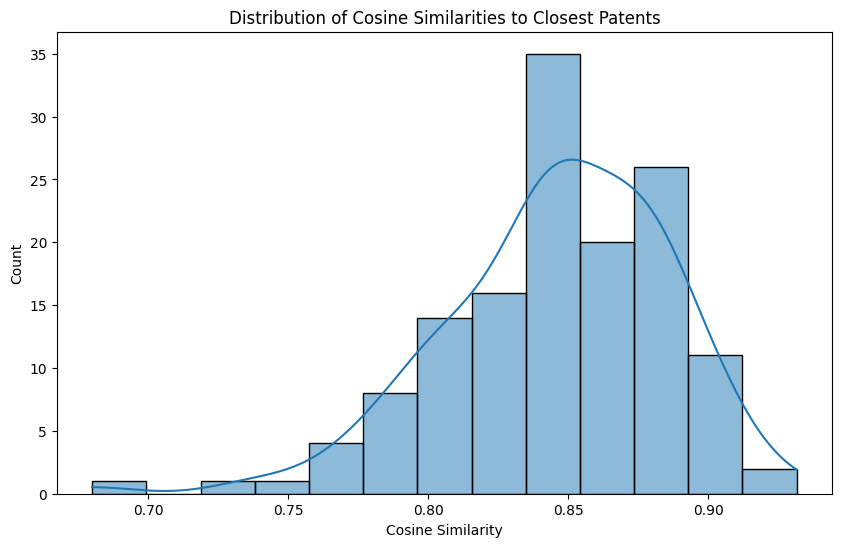

Number of patents with similarities calculated: 1135


TypeError: unsupported operand type(s) for +: 'NoneType' and 'NoneType'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cosine
import seaborn as sns

# Calculate cosine similarities
cosine_similarities = []

for patent in patents:

    cosine_similarities.append(patent.cosine_similarity_with_closest_patent)

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(cosine_similarities, kde=True)
plt.title("Distribution of Cosine Similarities to Closest Patents")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.show()

# Print some statistics
print(f"Number of patents with similarities calculated: {len(cosine_similarities)}")
print(f"Mean similarity: {np.mean(cosine_similarities):.4f}")
print(f"Median similarity: {np.median(cosine_similarities):.4f}")
print(f"Min similarity: {np.min(cosine_similarities):.4f}")
print(f"Max similarity: {np.max(cosine_similarities):.4f}")

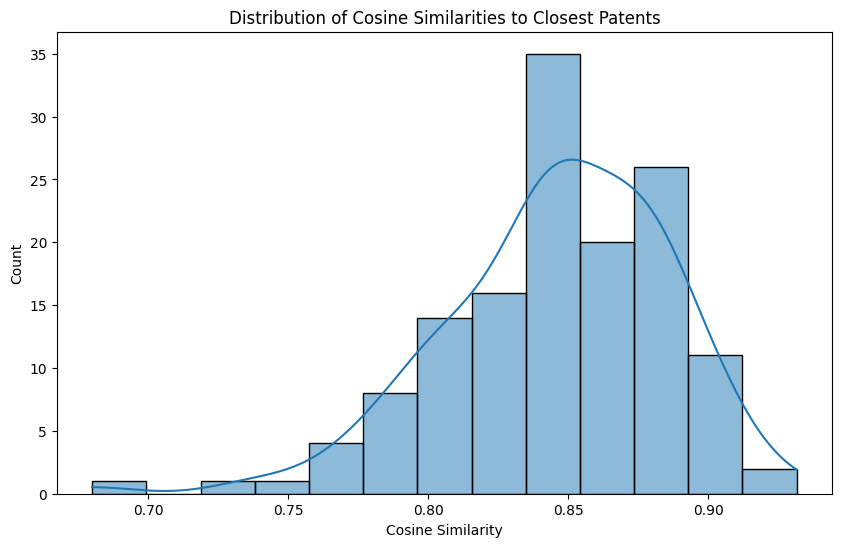

Number of patents with similarities calculated: 1135


TypeError: unsupported operand type(s) for +: 'NoneType' and 'NoneType'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cosine
import seaborn as sns

# Calculate cosine similarities
cosine_similarities = []

for patent in patents:

    cosine_similarities.append(patent.cosine_similarity_with_closest_patent)

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(cosine_similarities, kde=True)
plt.title("Distribution of Cosine Similarities to Closest Patents")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.show()

# Print some statistics
print(f"Number of patents with similarities calculated: {len(cosine_similarities)}")
print(f"Mean similarity: {np.mean(cosine_similarities):.4f}")
print(f"Median similarity: {np.median(cosine_similarities):.4f}")
print(f"Min similarity: {np.min(cosine_similarities):.4f}")
print(f"Max similarity: {np.max(cosine_similarities):.4f}")

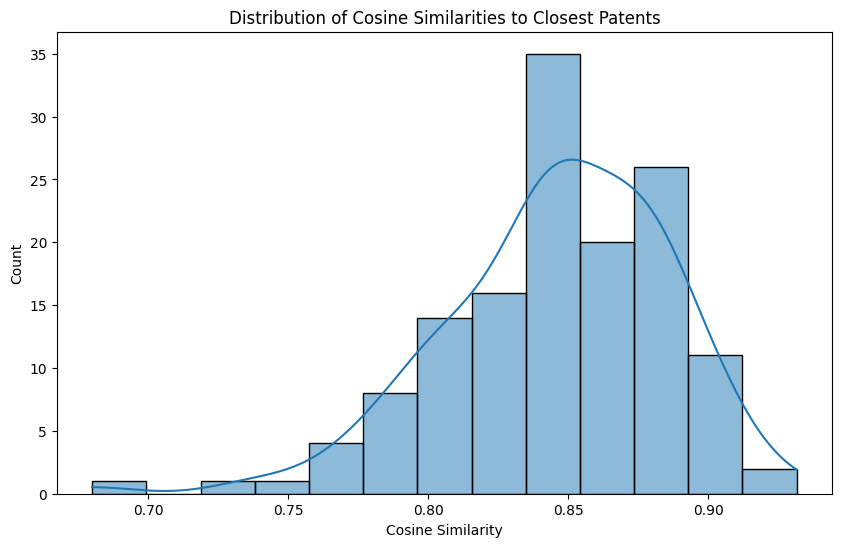

Number of patents with similarities calculated: 1135


TypeError: unsupported operand type(s) for +: 'NoneType' and 'NoneType'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cosine
import seaborn as sns

# Calculate cosine similarities
cosine_similarities = []

for patent in patents:

    cosine_similarities.append(patent.cosine_similarity_with_closest_patent)

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(cosine_similarities, kde=True)
plt.title("Distribution of Cosine Similarities to Closest Patents")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.show()

# Print some statistics
print(f"Number of patents with similarities calculated: {len(cosine_similarities)}")
print(f"Mean similarity: {np.mean(cosine_similarities):.4f}")
print(f"Median similarity: {np.median(cosine_similarities):.4f}")
print(f"Min similarity: {np.min(cosine_similarities):.4f}")
print(f"Max similarity: {np.max(cosine_similarities):.4f}")

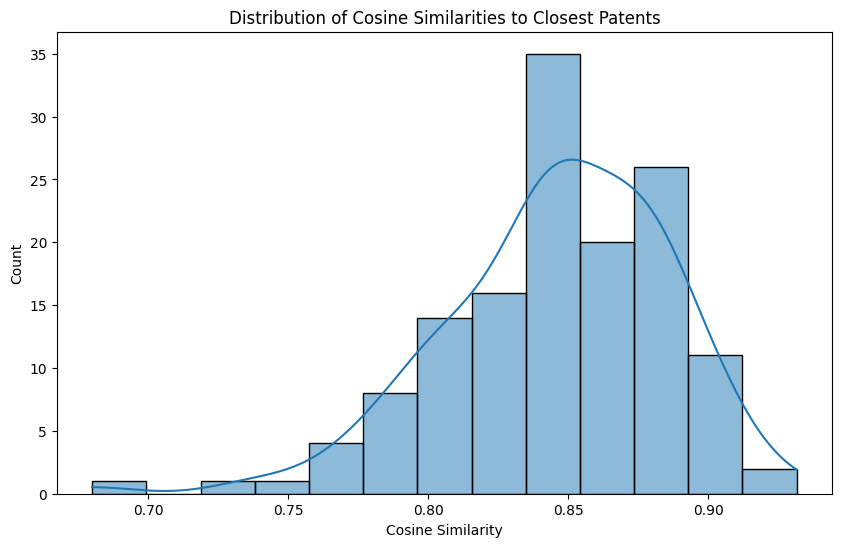

Number of patents with similarities calculated: 1135


TypeError: unsupported operand type(s) for +: 'NoneType' and 'NoneType'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cosine
import seaborn as sns

# Calculate cosine similarities
cosine_similarities = []

for patent in patents:

    cosine_similarities.append(patent.cosine_similarity_with_closest_patent)

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(cosine_similarities, kde=True)
plt.title("Distribution of Cosine Similarities to Closest Patents")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.show()

# Print some statistics
print(f"Number of patents with similarities calculated: {len(cosine_similarities)}")
print(f"Mean similarity: {np.mean(cosine_similarities):.4f}")
print(f"Median similarity: {np.median(cosine_similarities):.4f}")
print(f"Min similarity: {np.min(cosine_similarities):.4f}")
print(f"Max similarity: {np.max(cosine_similarities):.4f}")

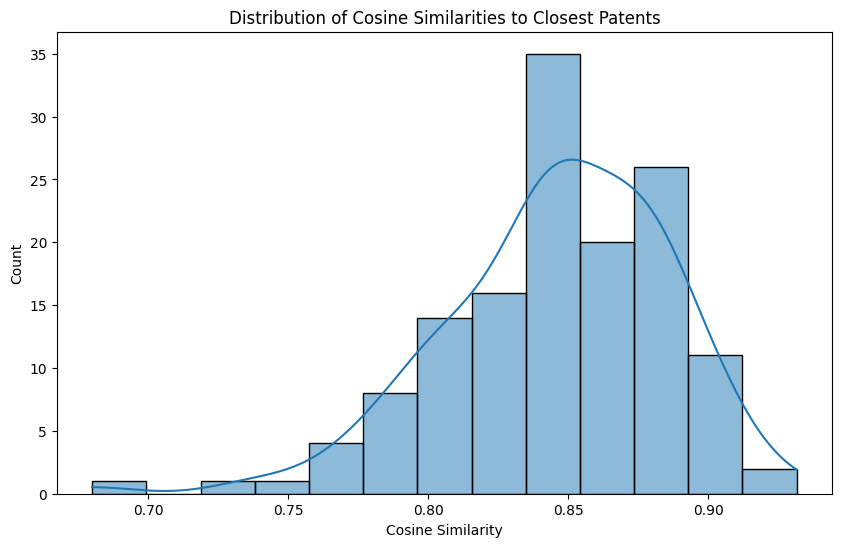

Number of patents with similarities calculated: 1135


TypeError: unsupported operand type(s) for +: 'NoneType' and 'NoneType'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cosine
import seaborn as sns

# Calculate cosine similarities
cosine_similarities = []

for patent in patents:

    cosine_similarities.append(patent.cosine_similarity_with_closest_patent)

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(cosine_similarities, kde=True)
plt.title("Distribution of Cosine Similarities to Closest Patents")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.show()

# Print some statistics
print(f"Number of patents with similarities calculated: {len(cosine_similarities)}")
print(f"Mean similarity: {np.mean(cosine_similarities):.4f}")
print(f"Median similarity: {np.median(cosine_similarities):.4f}")
print(f"Min similarity: {np.min(cosine_similarities):.4f}")
print(f"Max similarity: {np.max(cosine_similarities):.4f}")

In [23]:
pip install seaborn


  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


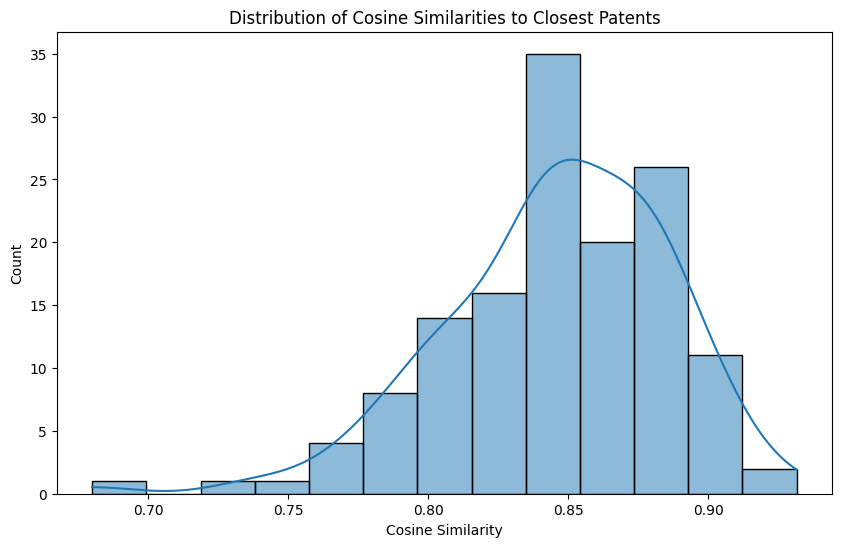

Number of patents with similarities calculated: 1135


TypeError: unsupported operand type(s) for +: 'NoneType' and 'NoneType'

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cosine
import seaborn as sns

# Calculate cosine similarities
cosine_similarities = []

for patent in patents:

    cosine_similarities.append(patent.cosine_similarity_with_closest_patent)

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(cosine_similarities, kde=True)
plt.title("Distribution of Cosine Similarities to Closest Patents")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.show()

# Print some statistics
print(f"Number of patents with similarities calculated: {len(cosine_similarities)}")
print(f"Mean similarity: {np.mean(cosine_similarities):.4f}")
print(f"Median similarity: {np.median(cosine_similarities):.4f}")
print(f"Min similarity: {np.min(cosine_similarities):.4f}")
print(f"Max similarity: {np.max(cosine_similarities):.4f}")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cosine
import seaborn as sns

# Calculate cosine similarities
cosine_similarities = []

for patent in patents:
    if patent.closest_patent is not None:
        similarity = 1 - cosine(patent.patent_embedding, patent.closest_patent.patent_embedding)
        cosine_similarities.append(similarity)

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(cosine_similarities, kde=True)
plt.title("Distribution of Cosine Similarities to Closest Patents")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.show()

# Print some statistics
print(f"Number of patents with similarities calculated: {len(cosine_similarities)}")
print(f"Mean similarity: {np.mean(cosine_similarities):.4f}")
print(f"Median similarity: {np.median(cosine_similarities):.4f}")
print(f"Min similarity: {np.min(cosine_similarities):.4f}")
print(f"Max similarity: {np.max(cosine_similarities):.4f}")

ValueError: Input vector should be 1-D.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cosine
import seaborn as sns

# Calculate cosine similarities
cosine_similarities = []

for patent in patents:
    if patent.closest_patent is not None:
        similarity = 1 - cosine(patent.patent_embedding, patent.closest_patent.patent_embedding)
        cosine_similarities.append(similarity)

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(cosine_similarities, kde=True)
plt.title("Distribution of Cosine Similarities to Closest Patents")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.show()

# Print some statistics
print(f"Number of patents with similarities calculated: {len(cosine_similarities)}")
print(f"Mean similarity: {np.mean(cosine_similarities):.4f}")
print(f"Median similarity: {np.median(cosine_similarities):.4f}")
print(f"Min similarity: {np.min(cosine_similarities):.4f}")
print(f"Max similarity: {np.max(cosine_similarities):.4f}")

ValueError: Input vector should be 1-D.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cosine
import seaborn as sns

# Calculate cosine similarities
cosine_similarities = []

for patent in patents:
    if patent.closest_patent is not None:
        similarity = 1 - cosine(patent.patent_embedding, patent.closest_patent.patent_embedding)
        cosine_similarities.append(similarity)

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(cosine_similarities, kde=True)
plt.title("Distribution of Cosine Similarities to Closest Patents")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.show()

# Print some statistics
print(f"Number of patents with similarities calculated: {len(cosine_similarities)}")
print(f"Mean similarity: {np.mean(cosine_similarities):.4f}")
print(f"Median similarity: {np.median(cosine_similarities):.4f}")
print(f"Min similarity: {np.min(cosine_similarities):.4f}")
print(f"Max similarity: {np.max(cosine_similarities):.4f}")

ValueError: Input vector should be 1-D.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cosine
import seaborn as sns

# Calculate cosine similarities
cosine_similarities = []

for patent in patents:
    if patent.closest_patent is not None:
        similarity = 1 - cosine(patent.patent_embedding, patent.closest_patent.patent_embedding)
        cosine_similarities.append(similarity)

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(cosine_similarities, kde=True)
plt.title("Distribution of Cosine Similarities to Closest Patents")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.show()

# Print some statistics
print(f"Number of patents with similarities calculated: {len(cosine_similarities)}")
print(f"Mean similarity: {np.mean(cosine_similarities):.4f}")
print(f"Median similarity: {np.median(cosine_similarities):.4f}")
print(f"Min similarity: {np.min(cosine_similarities):.4f}")
print(f"Max similarity: {np.max(cosine_similarities):.4f}")

ValueError: Input vector should be 1-D.